# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Group Members:

# Yifei Gu
# Cindy Wei

## Project Setup

In [81]:
# all import statements needed for the project, for example:
import math
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import sqlalchemy as db
import geopandas as gpd
import glob
import re
import os.path
import warnings
warnings.filterwarnings("ignore")

In [82]:
# any general notebook setup, like log formatting

In [83]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
TAXI_CSV = "taxi.csv"

EARTH_REDIUS = 6370.856
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA = [-73.891694, 40.763007, -73.850066, 40.790436]
JFK = [-73.829375, 40.617517, -73.743544, 40.670660]
EWR = [-74.205452, 40.664547, -74.146572, 40.716221]
sample_size = 10000
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"


## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [84]:
def rad(d):
    """ return the rad for given input"""
    
    return d * math.pi / 180.0

In [85]:
def calculate_distance(from_coord, to_coord):
    """ Calculate the distance between from_coord and to_coord"""
    
    radLat1 = rad(from_coord['pickup_latitude'])
    radLat2 = rad(to_coord['dropoff_latitude'])
    a = radLat1 - radLat2
    #print('a',a)
    b = rad(from_coord['pickup_longitude']) - rad(to_coord['dropoff_longitude'])
    #print(b)
    distance = 2 * math.asin(math.sqrt(math.pow(math.sin(a.iloc[0] / 2), 2) \
                                       + math.cos(radLat1.iloc[0]) * math.cos(radLat2.iloc[0]) * math.pow(math.sin(b.iloc[0] / 2), 2)))
    distance = distance * EARTH_REDIUS
    return distance


In [86]:
def add_distance_column(dataframe):
    """ Add the calculated distance as a column to the dataframe"""
    
    from_coord = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_coord = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    dataframe['distance'] = calculate_distance(from_coord, to_coord)


### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [87]:
def find_taxi_csv_urls():
    """ Programmatically download the Yellow Taxi Parquet files from 09-25"""
    url_list=[]
    try:
        response=requests.get(TAXI_URL)
        if response.status_code==200:
            soup=BeautifulSoup(response.content,'lxml')
            hrefs=soup.find_all('a',href=re.compile("yellow_tripdata"))
            for href in hrefs:
                url=href.get('href')
                date = url.split('/')[-1].split("_")[-1]
                year = int(date[:4])
                if year >= 2009 and year < 2015:
                    url_list.append(url)
                if year == 2015:
                    month = int(date[5:7])
                    if month <= 6:
                        url_list.append(url) 
            #print(url_list)
        return url_list
    except Exception as e:
        print(e)


In [88]:
columns = ["tpep_pickup_datetime", 
           "pickup_longitude", 
           "pickup_latitude", 
           "dropoff_longitude", 
           "dropoff_latitude",
           "tip_amount",
           "total_amount"]
columns2 = ["pickup_datetime", 
           "pickup_longitude", 
           "pickup_latitude", 
           "dropoff_longitude", 
           "dropoff_latitude",
           "tip_amount",
           "total_amount"]
columns3 = ["Trip_Pickup_DateTime", 
           "Start_Lon",
           "Start_Lat",
           "End_Lon", 
           "End_Lat",
           "Tip_Amt",
           "Total_Amt"]

In [89]:
def add_latlog_column(dataframe):
    """ 
    Get latitude and logitude from taxi_zones.
    Add pickup_latitude, dropoff_latitude, dropoff_latitude and dropoff_longitude as columns to the dataframe for convenient calculation
    """
    print('add_latlog_column')
    dftaxi = gpd.read_file('taxi_zones.shp')
    dftaxi = dftaxi.to_crs(epsg=4326)
    
    lat1=[]
    log1=[]
    lat2=[]
    log2=[]
    for LocationID in dataframe["PULocationID"]:
        lat=dftaxi[dftaxi["LocationID"]==LocationID].geometry.centroid.x
        log=dftaxi[dftaxi["LocationID"]==LocationID].geometry.centroid.y
        if lat.empty:
            lat1.append(0)
        else:
            lat1.append(lat.iloc[0])
        if log.empty:
            log1.append(0)
        else:
            log1.append(log.iloc[0])
    for LocationID in dataframe["DOLocationID"]:
        lat=dftaxi[dftaxi["LocationID"]==LocationID].geometry.centroid.x
        log=dftaxi[dftaxi["LocationID"]==LocationID].geometry.centroid.y
        if lat.empty:
            lat2.append(0)
        else:
            lat2.append(lat.iloc[0])
        if log.empty:
            log2.append(0)
        else:
            log2.append(log.iloc[0])
    dataframe['pickup_latitude']=lat1
    dataframe['pickup_longitude']=log1
    dataframe['dropoff_latitude']=lat2
    dataframe['dropoff_longitude']=log2
    dataframe.to_csv("2.csv")

In [90]:
def get_and_clean_month_taxi_data(url):
    """ 
    Download Parquet files, get some sample from these files
    Clean the dataframe according to existing location IDs
    Write data into .csv and return dataframe
    """
    reponse = requests.get(url)

    filename=url.split('/')[-1]
    with open(filename, "wb") as f:
        f.write(reponse.content)
    
    df = pd.read_parquet(filename)
    print(filename)
    print(df.columns)
    df = df.sample(n=sample_size,ignore_index=True)
    '''
    df.columns = df.columns.str.strip()
    print(df.columns)
   
    df=df.sample(n=sample_size,ignore_index=True)
    add_latlog_column(df)
    df = df[columns]
    df.columns = columns2
    df = df[columns2]
    '''
    try:
        if "PULocationID" in df.columns:
            add_latlog_column(df)
        df = df[columns]
    except:
        try:
            df = df[columns2]
        except:
            try:
                df = df[columns3]
            except:
                add_latlog_column(df)
                df = df[columns2]
    df.columns = columns2
   # df.to_csv("3.csv")
    #print(df["pickup_longitude"])
    '''
    df=df[df["pickup_longitude"] > -74.242330]
    df = df[(df["pickup_longitude"] > -74.242330) 
           &(df["pickup_longitude"] < -73.717047)
           & (df["pickup_latitude"] > 40.560445) 
           & (df["pickup_latitude"] < 40.908524)
    '''
    df = df.sample(n=sample_size,random_state = 1,ignore_index=True)
    return df


In [91]:
def get_and_clean_taxi_data():
    """ 
    Get taxi data. If taxi.csv exists, read-only. Otherwise, download data and generate taxi.csv file
    """
    all_taxi_dataframes = []
    if os.path.exists(TAXI_CSV):
        taxi_data=pd.read_csv(TAXI_CSV)
    else:
        all_csv_urls = find_taxi_csv_urls()
        for csv_url in all_csv_urls[0:2]:
            dataframe = get_and_clean_month_taxi_data(csv_url)
            add_distance_column(dataframe)
            all_taxi_dataframes.append(dataframe)
        print(all_taxi_dataframes)
        taxi_data = pd.concat(all_taxi_dataframes)
        taxi_data.to_csv(TAXI_CSV)
    return taxi_data


### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [92]:
def load_and_clean_uber_data(csv_file):
    """ Load the uber data into dataframe,filter data, and reformat columns to desired name"""
    df=pd.read_csv(csv_file)
    df=df[(df["pickup_longitude"] > -74.242330) 
           &(df["pickup_longitude"] < -73.717047)
           & (df["pickup_latitude"] > 40.560445) 
           & (df["pickup_latitude"] < 40.908524)]
    print(df)
    df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])
    df["dayofweek"] = df["pickup_datetime"].dt.dayofweek
    df["year"] = df["pickup_datetime"].dt.year
    df["month"] = df["pickup_datetime"].dt.month
    df["day"] = df["pickup_datetime"].dt.day
    df["hour"] = df["pickup_datetime"].dt.hour
    return df



In [93]:
def get_uber_data():
    """ Load cleaned uber data into dataframe, and add distance column, and return"""
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe


### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [94]:
def clean_month_weather_data_hourly(csv_file):
    """ Load weather data and clean the dataframe to generate hourly weather data"""
    df = pd.read_csv(csv_file)
    df = df[['DATE', 'HourlyWindSpeed', 'HourlyPrecipitation']]
    df = df.dropna() 
    #df.to_csv("12.csv")
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'].replace(['T'], ''), errors='coerce')
    df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'].replace(['T'], ''), errors='coerce')
    df['DATE'] = pd.to_datetime(df['DATE'])
    #df.to_csv("121.csv")
    return df


In [95]:
def clean_month_weather_data_daily(csv_file):
    """ Load weather data, clean and calculate from the dataframe to generate daily weather data"""
    df = pd.read_csv(csv_file)
    df = df[['HourlyWindSpeed','HourlyPrecipitation','DATE']]
    df = df.dropna()  
    #df.to_csv("13.csv")
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'].replace(['T'], ''), errors='coerce')
    df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'].replace(['T'], ''), errors='coerce')
    df['DATE'] = pd.to_datetime(df['DATE']).dt.strftime('%Y-%m-%d')
    daily_df = df.groupby(['DATE']).agg({'HourlyWindSpeed': 'mean', 'HourlyPrecipitation': 'sum'})
    daily_df.rename(columns = {'HourlyWindSpeed':'DailyWindSpeed', 'HourlyPrecipitation':'DailyPrecipitation'}, inplace = True)
    #daily_df.to_csv("131.csv")
    return daily_df.reset_index()


In [96]:
def load_and_clean_weather_data():
    """ Load weather data, and generate hourly_dataframes and daily_dataframes and return for future calculation"""
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files =glob.glob("*weather*.csv") 
    print(weather_csv_files) 
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data


### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [97]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

        Unnamed: 0                            key  fare_amount  \
0         24238194    2015-05-07 19:52:06.0000003          7.5   
1         27835199    2009-07-17 20:04:56.0000002          7.7   
2         44984355   2009-08-24 21:45:00.00000061         12.9   
3         25894730    2009-06-26 08:22:21.0000001          5.3   
4         17610152  2014-08-28 17:47:00.000000188         16.0   
...            ...                            ...          ...   
199995    42598914   2012-10-28 10:49:00.00000053          3.0   
199996    16382965    2014-03-14 01:09:00.0000008          7.5   
199997    27804658   2009-06-29 00:42:00.00000078         30.9   
199998    20259894    2015-05-20 14:56:25.0000004         14.5   
199999    11951496   2010-05-15 04:08:00.00000076         14.1   

                pickup_datetime  pickup_longitude  pickup_latitude  \
0       2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1       2009-07-17 20:04:56 UTC        -73.994355        40.728225 

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [98]:
engine = db.create_engine(DATABASE_URL)

In [99]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """                                   
CREATE TABLE IF NOT EXISTS hourly_weather(                                  
   DATE timestamp PRIMARY KEY,                                
   HourlyWindSpeed FLOAT,                                     
   HourlyPrecipitation FLOAT                                  
);                                                            
"""                                                           
                                                              
DAILY_WEATHER_SCHEMA = """                                    
CREATE TABLE IF NOT EXISTS daily_weather(                                   
   DATE timestamp PRIMARY KEY,                                
   DailyWindSpeed FLOAT,                                      
   DailyPrecipitation FLOAT                                   
);                                                            
"""                                                           
                              
TAXI_TRIPS_SCHEMA = """       
CREATE TABLE IF NOT EXISTS taxis_trips(     
   pickup_datetime timestamp, 
   tip_amount FLOAT,          
   pickup_longitude DOUBLE,   
   pickup_latitude DOUBLE,    
   dropoff_longitude DOUBLE,  
   dropoff_latitude DOUBLE,   
   distance DOUBLE            
);                            
"""                           
                              
UBER_TRIPS_SCHEMA = """       
CREATE TABLE IF NOT EXISTS uber_trips(      
   pickup_datetime timestamp, 
   pickup_longitude DOUBLE,   
   pickup_latitude DOUBLE,    
   dropoff_longitude DOUBLE,  
   dropoff_latitude DOUBLE,   
   distance DOUBLE            
);                            
""" 


In [100]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [101]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)


### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [102]:
def write_dataframes_to_table(table_to_df_dict):
    """ Load the data in dataframes to tables"""
    for table_name, df in table_to_df_dict.items():
        df.to_sql(name=table_name, con=engine.connect(), index=False, if_exists='replace')


In [103]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [104]:
""" dataframe to sql tables"""
write_dataframes_to_table(map_table_name_to_dataframe)

In [105]:
""" Test tables"""
with engine.connect() as connection:
    result = connection.execute("select * from taxis_trips limit 10").fetchall()
    for row in result:
        print(row)

    result = connection.execute("select * from uber_trips limit 10").fetchall()
    for row in result:
        print(row)

    result = connection.execute("select * from hourly_weather limit 10").fetchall()
    for row in result:
        print(row)

    result = connection.execute("select date from daily_weather limit 10").fetchall()
    for row in result:
        print(row) 

(24238194, '2015-05-07 19:52:06.0000003', 7.5, '2015-05-07 19:52:06.000000', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, 1, 3, 2015, 5, 7, 19, 1.683284705239794)
(27835199, '2009-07-17 20:04:56.0000002', 7.7, '2009-07-17 20:04:56.000000', -73.994355, 40.728225, -73.99471, 40.750325, 1, 4, 2009, 7, 17, 20, 1.683284705239794)
(44984355, '2009-08-24 21:45:00.00000061', 12.9, '2009-08-24 21:45:00.000000', -74.005043, 40.74077, -73.962565, 40.772647, 1, 0, 2009, 8, 24, 21, 1.683284705239794)
(25894730, '2009-06-26 08:22:21.0000001', 5.3, '2009-06-26 08:22:21.000000', -73.976124, 40.790844, -73.965316, 40.803349, 3, 4, 2009, 6, 26, 8, 1.683284705239794)
(17610152, '2014-08-28 17:47:00.000000188', 16.0, '2014-08-28 17:47:00.000000', -73.925023, 40.744085, -73.97308199999999, 40.761247, 5, 3, 2014, 8, 28, 17, 1.683284705239794)
(44470845, '2011-02-12 02:27:09.0000006', 4.9, '2011-02-12 02:27:09.000000', -73.96901899999999, 40.75591, -73.96901899999999, 40.75591, 

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [106]:
def write_query_to_file(query, outfile):
    """ Write the given query into the output file"""
    with open(outfile, "w+") as f:
        f.write(query)
        f.write('\n') 

### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [107]:
QUERY_1 = """
SELECT STRFTIME('%H', pickup_datetime) as hour,
       COUNT(*) as ORDERPERHOUR
FROM taxi_trips
GROUP BY STRFTIME('%H', pickup_datetime)
"""

In [108]:
result=engine.execute(QUERY_1).fetchall()
for row in result:
    print(row)      
write_query_to_file(QUERY_1, "most_popular_hour_to_take_yellow_taxi.sql")

('00', 783)
('01', 590)
('02', 383)
('03', 273)
('04', 202)
('05', 193)
('06', 440)
('07', 711)
('08', 921)
('09', 939)
('10', 855)
('11', 956)
('12', 1038)
('13', 997)
('14', 1016)
('15', 1005)
('16', 866)
('17', 1084)
('18', 1202)
('19', 1240)
('20', 1142)
('21', 1130)
('22', 1030)
('23', 1004)


In [109]:
QUERY_2 = """
SELECT STRFTIME('%w', pickup_datetime) as weekday,
       COUNT(*) as DAROFWEEK
FROM uber_trips
GROUP BY STRFTIME('%w', pickup_datetime)
"""

In [110]:
result=engine.execute(QUERY_2).fetchall()
for row in result:
    print(row)

('0', 25877)
('1', 24733)
('2', 27579)
('3', 28381)
('4', 29389)
('5', 30223)
('6', 29643)


In [111]:
write_query_to_file(QUERY_2, "most_popular_week_to_take_uber.sql")

In [112]:
QUERY_31="""
CREATE TABLE  IF NOT EXISTS hired_trips  as 
SELECT pickup_datetime , distance 
FROM taxi_trips WHERE STRFTIME('%Y', pickup_datetime) = 2013 AND STRFTIME('%m', pickup_datetime) = '07'
UNION ALL
SELECT pickup_datetime, distance 
FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = 2013 AND STRFTIME('%m', pickup_datetime) = '07';
"""

In [113]:
QUERY_32 = """
SELECT
  distance AS '95% distance'
FROM hired_trips
ORDER BY distance ASC
LIMIT 1
OFFSET (SELECT
         COUNT(*)
        FROM hired_trips) * 95 / 100 - 1;
"""

In [114]:
engine.execute("DROP TABLE  IF EXISTS  hired_trips")


In [115]:
engine.execute(QUERY_31)
result=engine.execute(QUERY_32).fetchall()
for row in result:
    print(row)

In [116]:
write_query_to_file(QUERY_31+"\n"+QUERY_32, "95%Percentile_distance_all_hired_trips.sql")


In [117]:
QUERY_41="""
CREATE TABLE  IF NOT EXISTS hired_trips  as 
SELECT pickup_datetime , distance 
FROM taxi_trips WHERE STRFTIME('%Y', pickup_datetime) = 2009 
UNION ALL
SELECT pickup_datetime, distance 
FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = 2009 ;
"""

In [118]:
QUERY_42 = """
SELECT STRFTIME('%j', pickup_datetime),AVG(distance) from hired_trips GROUP BY STRFTIME('%j', pickup_datetime) 
HAVING COUNT(*) IN (  SELECT DISTINCT COUNT(*)
  FROM hired_trips data
  GROUP BY STRFTIME('%j', pickup_datetime)
  ORDER BY count(*) DESC
  LIMIT 10);
"""

In [119]:
engine.execute("DROP TABLE  IF EXISTS  hired_trips")
engine.execute(QUERY_41)
result=engine.execute(QUERY_42).fetchall()
for row in result:
    print(row)

In [120]:
write_query_to_file(QUERY_41+"\n"+QUERY_42, " top_10_days_with_the_highest_number_and_average_of_hired_rides.sql")

In [121]:
QUERY_51 = """
CREATE TABLE IF NOT EXISTS hired_trips as 
SELECT pickup_datetime , distance 
FROM taxi_trips WHERE STRFTIME('%Y', pickup_datetime) = 2014
UNION ALL
SELECT pickup_datetime, distance 
FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = 2014;
"""


In [122]:
QUERY_52 = """
SELECT STRFTIME('%j', pickup_datetime), COUNT(*) from hired_trips GROUP BY STRFTIME('%j', pickup_datetime) 
HAVING STRFTIME('%j', pickup_datetime) IN (
  SELECT STRFTIME('%j', DATE) from daily_weather
  ORDER BY DailyWindSpeed  DESC
  LIMIT 10
);
"""


In [123]:
engine.execute("DROP TABLE  IF EXISTS  hired_trips")
engine.execute(QUERY_51)
result=engine.execute(QUERY_52).fetchall()
for row in result:
    print(row)


In [124]:
write_query_to_file(QUERY_51+"\n"+QUERY_52, " top_10_windiest _days_and_number_of_hired_trips.sql")

In [125]:
QUERY_61 ="""
CREATE TABLE IF NOT EXISTS hired_trips as 
SELECT STRFTIME('%j', pickup_datetime) as DATE, STRFTIME('%H', pickup_datetime) as HOUR from 
(SELECT pickup_datetime 
FROM taxi_trips WHERE STRFTIME('%Y', pickup_datetime) = 2012 AND 
STRFTIME('%m', pickup_datetime) = '10' AND STRFTIME('%j', pickup_datetime) <= '30'  AND STRFTIME('%j', pickup_datetime) <= '22'
UNION ALL
SELECT pickup_datetime
FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = 2012 AND STRFTIME('%m', pickup_datetime) = '10' 
AND STRFTIME('%j', pickup_datetime) <= '30'  AND STRFTIME('%j', pickup_datetime) <= '22');

"""

QUERY_62 ="""
SELECT COUNT(*), HourlyPrecipitation, HourlyWindSpeed from hired_trips INNER JOIN hourly_weather 
ON hired_trips.DATE = STRFTIME('%j', hourly_weather.DATE) 
AND hired_trips.HOUR =STRFTIME('%h', hourly_weather.DATE)
GROUP BY hourly_weather.DATE, STRFTIME('%h', hourly_weather.DATE);
"""

In [126]:
engine.execute("DROP TABLE  IF EXISTS  hired_trips")
#engine.execute(QUERY_60)
engine.execute(QUERY_61)
result=engine.execute(QUERY_62).fetchall()
for row in result:
    print(row)
    

In [127]:
write_query_to_file(QUERY_61+"\n"+QUERY_62, "trips_were_taken_each_hour_and_precipitation_received_and_sustained_wind_speed.sql")  



## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [128]:
# use a more descriptive name for your function
def plot_visual_1(dataframe):
    plt.title("Number of ORDERPERHOUR in Each Hour")
    plt.xlabel("Hour")
    plt.ylabel("Number of ORDERPERHOUR")
    plt.plot(dataframe['HOUR'],dataframe['ORDERPERHOUR'])
    plt.show()

   HOUR  ORDERPERHOUR
0    00           783
1    01           590
2    02           383
3    03           273
4    04           202
5    05           193
6    06           440
7    07           711
8    08           921
9    09           939
10   10           855
11   11           956
12   12          1038
13   13           997
14   14          1016
15   15          1005
16   16           866
17   17          1084
18   18          1202
19   19          1240
20   20          1142
21   21          1130
22   22          1030
23   23          1004
0     00
1     01
2     02
3     03
4     04
5     05
6     06
7     07
8     08
9     09
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
Name: HOUR, dtype: object


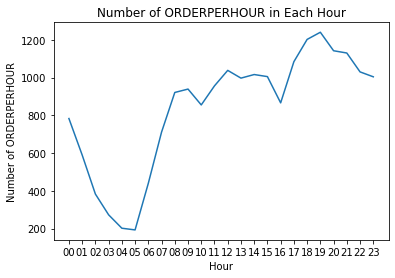

In [129]:
result=engine.execute(QUERY_1).fetchall()
df=pd.DataFrame(result)
df.columns = ['HOUR','ORDERPERHOUR']
print(df)
print(df.iloc[:,0])
plot_visual_1(df)

In [130]:
# use a more descriptive name for your function
def plot_visual_2(dataframe):
    x = dataframe["month"]
    y = dataframe["ave_distance"]
    ci = 1.645 * dataframe["ave_distance"]/np.sqrt(dataframe["count"])
    plt.plot(x, y)
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.title("Average distance in each month")
    plt.xlabel("Month")
    plt.ylabel("Average distance")
    plt.show()


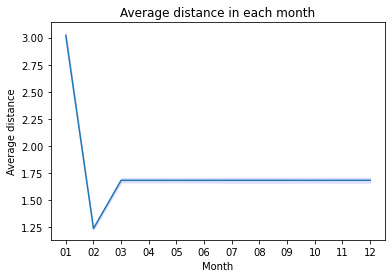

In [131]:
QUERY_2 = """
SELECT 
    month, AVG(distance) AS ave_distance,
    COUNT(*) as count
FROM (SELECT STRFTIME('%m', pickup_datetime) as month , distance 
FROM taxi_trips 
UNION ALL
SELECT  STRFTIME('%m', pickup_datetime) as month, distance
FROM uber_trips )
GROUP BY month
"""
result=engine.execute(QUERY_2).fetchall()
df=pd.DataFrame(result)
df.columns = ['month','ave_distance','count']
plot_visual_2(df)

In [132]:
def plot_visual_3(lga_rides,jfk_rides,ewr_rides):
    plt.plot(lga_rides["day"], lga_rides["num_airports"], label="LGA")
    plt.plot(jfk_rides["day"], jfk_rides["num_airports"], label="JFK")
    plt.plot(ewr_rides["day"], ewr_rides["num_airports"], label="EWR")
    plt.legend()
    plt.title("Number of rides in day of the week")
    plt.xlabel("Day of the week")
    plt.ylabel("Number of rides")
    plt.show()

In [133]:
all_airports = pd.concat([taxi_data, uber_data], axis=0, ignore_index=True)


In [134]:
def filterBox(df, box):
    df = df[
         (df["dropoff_longitude"] > box[0]) 
       & (df["dropoff_longitude"] < box[2]) 
       & (df["dropoff_latitude"] > box[1]) 
       & (df["dropoff_latitude"] < box[3])]
    return df

In [135]:
lga_airports = filterBox(all_airports, LGA)
jfk_airports = filterBox(all_airports, JFK)
ewr_airports = filterBox(all_airports, EWR)

In [136]:
map_table_name_to_dataframe = {
    "lga_airports": lga_airports,
    "jfk_airports": jfk_airports,
    "ewr_airports": ewr_airports
}  
write_dataframes_to_table(map_table_name_to_dataframe) 

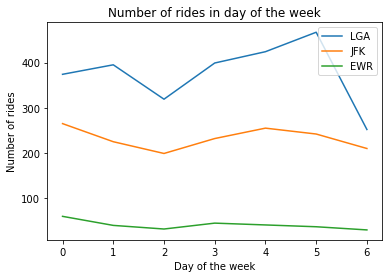

In [137]:
query = """
SELECT STRFTIME('%w', pickup_datetime) AS day, COUNT(*) as num_airports
FROM lga_airports
GROUP BY STRFTIME('%w', pickup_datetime)
"""
result=engine.execute(query).fetchall()
lga_airports = pd.DataFrame(result)
lga_airports.columns = ['day','num_airports']
query = """
SELECT STRFTIME('%w', pickup_datetime)  AS day, COUNT(*) as num_airports
FROM jfk_airports
GROUP BY STRFTIME('%w', pickup_datetime)
"""
result=engine.execute(query).fetchall()
jfk_airports = pd.DataFrame(result)
jfk_airports.columns = ['day','num_airports']
query = """
SELECT STRFTIME('%w', pickup_datetime) AS day, COUNT(*) as num_airports
FROM ewr_airports
GROUP BY STRFTIME('%w', pickup_datetime)
"""
result=engine.execute(query).fetchall()
ewr_airports = pd.DataFrame(result)
ewr_airports.columns = ['day','num_airports']
plot_visual_3(lga_airports,jfk_airports,ewr_airports)
